In [1]:
from skimage import io
import dlib
import numpy as np

import os
import re
import skimage.transform as tr
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from IPython.core.display import display

# Image processing

Main approach was taken from https://habr.com/ru/post/317798/ 

### Считывание массива ключевых точек лица

In [2]:
face_template=np.load('preprocess weights/face_template.npy')

### Считывание фотографии себя

In [7]:
path_me="display images/me.jpg"
image=plt.imread(path_me)
detector = dlib.get_frontal_face_detector()
face_rects = list(detector(image, 1))
face_rect = face_rects[0]

RuntimeError: Expected writable numpy.ndarray with shape set.

### Считываем обученную модель предиктора для сегментации

In [6]:
dlib_predictor_path="preprocess weights/shape_predictor_68_face_landmarks.dat" # путь готового предсказателя
predictor = dlib.shape_predictor(dlib_predictor_path)                       # предсказатель , работающий на сегментации
points = predictor(image, face_rect)                                        # результат работы [p1,p2..], p1.x,p1.y
landmarks = np.array(list(map(lambda p: [p.x, p.y], points.parts())))       # результат работы [[x1,y1],[x2,y2]..]

NameError: name 'face_rect' is not defined

### Создание все точек контура лица на изображении

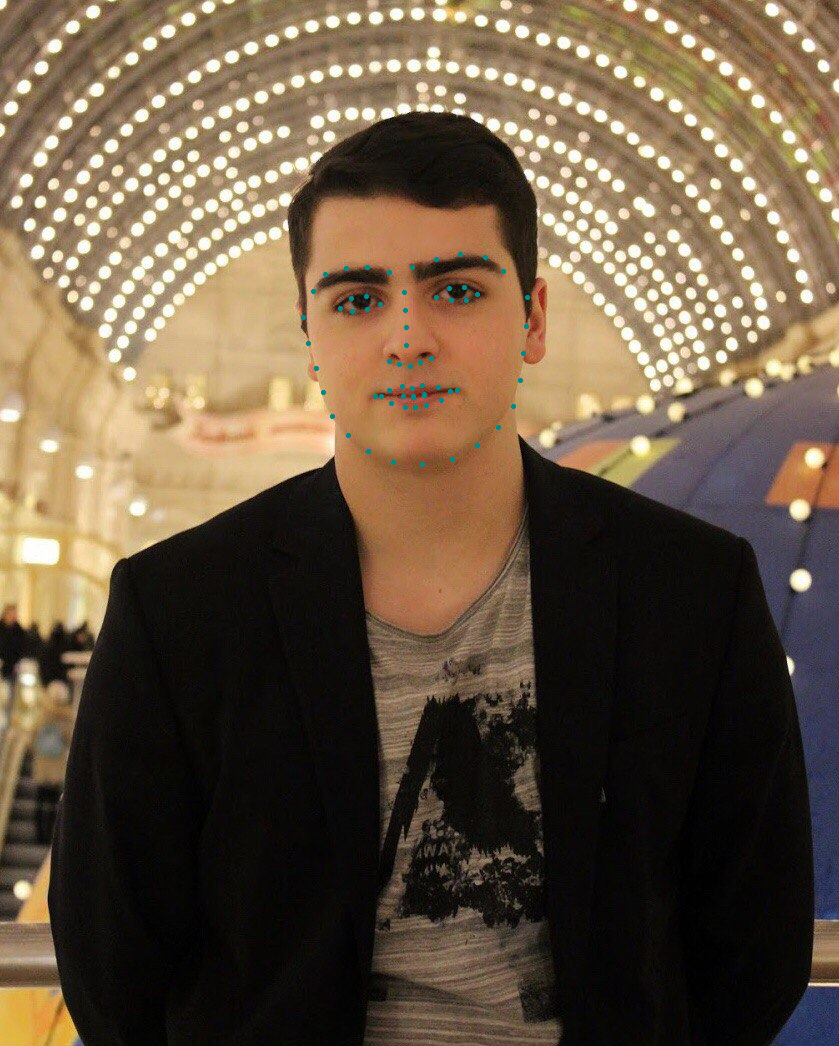

In [36]:
photo=Image.open(path_me)   # считываем фотографию
pix=photo.load()            # загружаем пиксели
draw=ImageDraw.Draw(photo)  # создаем инструмент для рисования
N=2

for point in landmarks:     # рисуем точки 

    draw.ellipse(((point[0]-N,point[1]-N),(point[0]+N,point[1]+N)),fill=(0,139,139))
display(photo)

### Выбор главных 3х точек

In [38]:
INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]                          # положение главных точек в массиве
proper_landmarks = 227 * face_template[INNER_EYES_AND_BOTTOM_LIP] # куда хотим переместить
current_landmarks = landmarks[INNER_EYES_AND_BOTTOM_LIP]          # позиции трех опорных точен на изображении

### Создание 3 главных точек

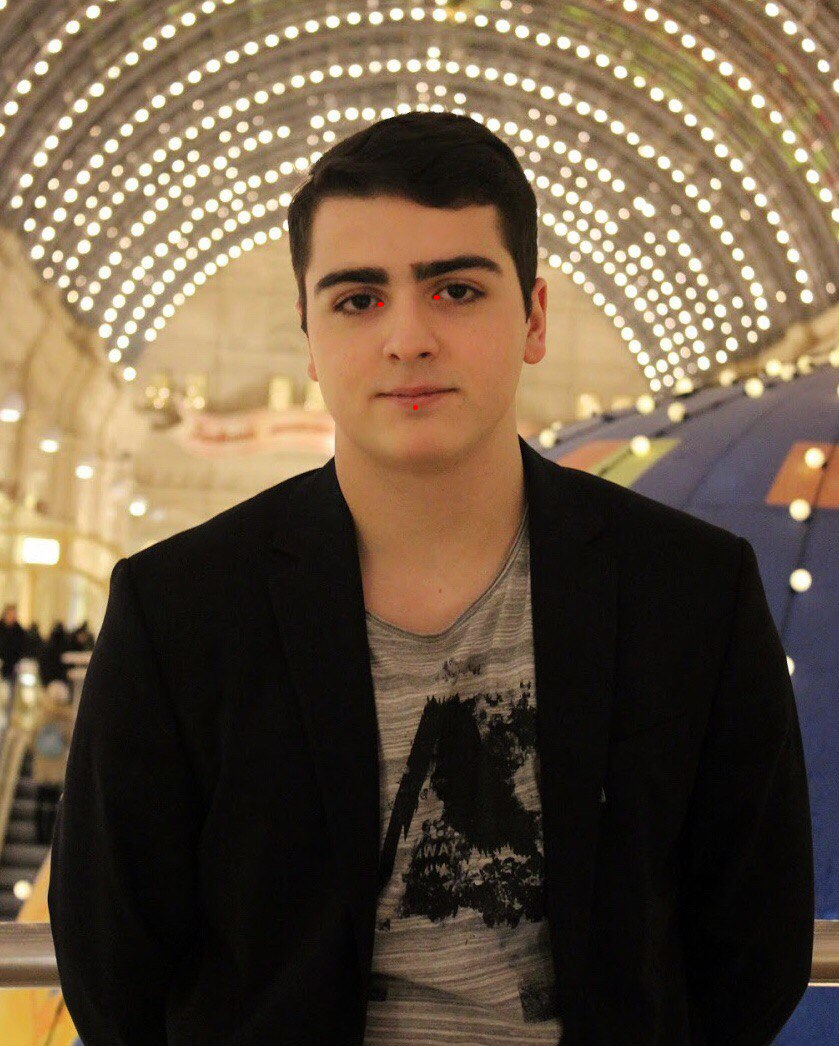

In [39]:
photo=Image.open(path_me)
pix=photo.load()
draw=ImageDraw.Draw(photo)
for point in current_landmarks:

    draw.ellipse(((point[0]-N,point[1]-N),(point[0]+N,point[1]+N)),fill=(255,0,0))
display(photo)


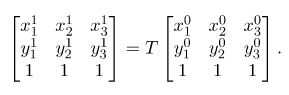

In [46]:
path_matrix="../face_net_mkr/images/matrix.jpg"
image_matrix=Image.open(path_matrix)
display(image_matrix)

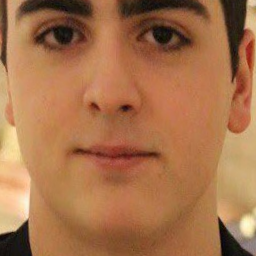

In [44]:
size=256
A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
T = np.linalg.solve(A, B).T

wrapped = tr.warp(
image,
tr.AffineTransform(T).inverse,
output_shape=(size, size),
mode='constant',
cval=0,
preserve_range=True
)
im = Image.fromarray(wrapped.astype(np.uint8))
display(im)

## Создадим функцию, в которой совмещены все вышеперечисленные методы обработки и также обрезка фотографий с помощью аффиного отображения


In [8]:

def make_photo(path):

    files_names=os.listdir(path)
    folder_names=list(set([ name[:4] for name in files_names]))

    os.mkdir('dataset')
    for i,name in enumerate(folder_names):
        os.mkdir('dataset/'+str(i))
    size=128
        
    face_template=np.load('face_template.npy')
    predictor=dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    detector=dlib.get_frontal_face_detector()
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    
    for name in files_names:
        image=io.imread(path+'/'+name)

        face_rects=list(detector(image,1))
        try:
            face_rect=face_rects[0]

            points=predictor(image,face_rect)
            landmarks=np.array(list(map(lambda p: [p.x,p.y],points.parts())))

            proper_landmarks=size*face_template[INNER_EYES_AND_BOTTOM_LIP]
            current_landmarks = landmarks[INNER_EYES_AND_BOTTOM_LIP]

            A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
            B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
            T = np.linalg.solve(A, B).T

            wrapped = tr.warp(
            image,
            tr.AffineTransform(T).inverse,
            output_shape=(size, size),
            mode='constant',
            cval=0,
            preserve_range=True
            )
            im = Image.fromarray(wrapped.astype(np.uint8))
            way=name[:4]

            namel=name[6:10]
            im.save('dataset/'+str(folder_names.index(way))+'/'+str(namel)+'.jpg')
        except Exception:
            pass

In [47]:
#make_photo('photo')   
  

## Удалим тех людей в датасете, чье количество фотографий меньше порогового значения

In [ ]:
path='dataset'
N=11
files_names=os.listdir(path)
folder_names=list(set([ name[:4] for name in files_names]))
for i in folder_names:
    if len(os.listdir(path+'/'+str(i)))<N:
        for j in os.listdir(path+'/'+str(i)):
            os.remove(path+'/'+str(i)+'/'+j)
        os.rmdir(path+'/'+str(i))
